In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
import geopandas as gpd
import rioxarray

In [2]:
# Replace 'path_to_your_file.nc' with the actual path to your NetCDF file
path_to_file = 'combined_rainfall_new.nc'

# Open the NetCDF file as an xarray dataset
ds = xr.open_dataset(path_to_file)

# Now you can work with the xarray dataset 'ds'
ds

<xarray.Dataset>
Dimensions:    (latitude: 774, longitude: 366, time: 15705)
Coordinates:
  * latitude   (latitude) float32 -4.475 -4.425 -4.375 ... 34.07 34.12 34.17
  * longitude  (longitude) float32 22.43 22.47 22.52 22.57 ... 40.57 40.62 40.68
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2023-12-31
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [3]:
def clip_netcdf(input_file, output_file, lat_min, lat_max, lon_min, lon_max):
    # Open the NetCDF file with dask
    ds = xr.open_dataset(input_file, chunks={'time': 1000})  # Adjust chunk size as needed

    # Clip the data based on the latitude and longitude extents
    clipped_ds = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

    # Ensure latitude and longitude are kept as coordinates
    if 'latitude' in clipped_ds.coords and 'longitude' in clipped_ds.coords:
        clipped_ds = clipped_ds.set_coords(['latitude', 'longitude'])

    # Explicitly set encoding for each variable to avoid conflicts
    encoding = {var: {"zlib": True} for var in clipped_ds.data_vars}
    encoding.update({'latitude': {'dtype': 'float32'}, 'longitude': {'dtype': 'float32'}})

    # Save the clipped dataset to a new NetCDF file using dask
    clipped_ds.to_netcdf(output_file, encoding=encoding, compute=True)

# Define your input and output file paths and the lat/lon extents
input_file = 'combined_rainfall_new.nc'
output_file = 'clipped_output_BN_Trib_below_beko_abo.nc'
lat_min = 8.677112763479752
lat_max = 11.26538575937442
lon_min = 36.870924538054325
lon_max = 39.08539880806486

# Call the function to clip the NetCDF file
clip_netcdf(input_file, output_file, lat_min, lat_max, lon_min, lon_max)

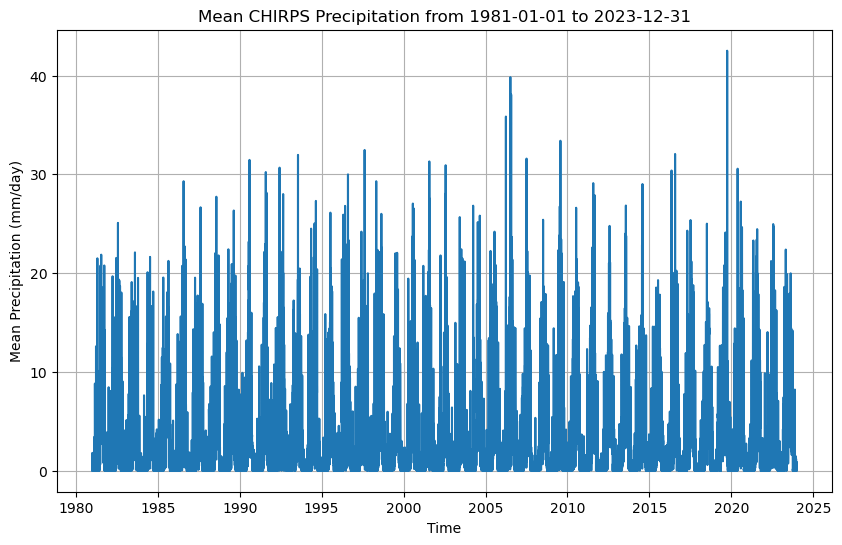

In [4]:
# Load CHIRPS data into an xarray dataset (replace 'path_to_your_chirps_file.nc' with your file path)
ds = xr.open_dataset('clipped_output_BN_Trib_below_beko_abo.nc')

# Specify the time range you want to plot (replace 'start_date' and 'end_date' with your desired dates)
start_date = '1981-01-01'
end_date = '2023-12-31'

# Select data within the specified time range
data_for_range = ds.sel(time=slice(start_date, end_date))

# Calculate the mean precipitation across all latitudes and longitudes
mean_precipitation = data_for_range['precip'].mean(dim=('latitude', 'longitude'))

# Extract the time dimension
time_data = data_for_range['time']

# Plot mean precipitation against time using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(time_data, mean_precipitation)
plt.title(f'Mean CHIRPS Precipitation from {start_date} to {end_date}')
plt.xlabel('Time')
plt.ylabel('Mean Precipitation (mm/day)')
plt.grid(True)
plt.show()

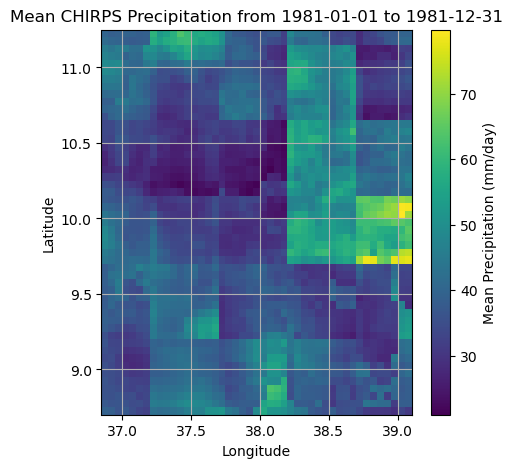

In [5]:
# Load CHIRPS data into an xarray dataset (replace 'path_to_your_chirps_file.nc' with your file path)
ds = xr.open_dataset('clipped_output_BN_Trib_below_beko_abo.nc')

# Specify the time range you want to plot (replace 'start_date' and 'end_date' with your desired dates)
start_date = '1981-01-01'
end_date = '1981-12-31'

# Select data within the specified time range
data_for_range = ds.sel(time=slice(start_date, end_date))

# Calculate the mean precipitation over time for each latitude and longitude
mean_precipitation_spatial = data_for_range['precip'].max(dim='time')

# Get the latitude and longitude data
latitudes = mean_precipitation_spatial['latitude']
longitudes = mean_precipitation_spatial['longitude']

# Plotting the mean precipitation as a raster plot
plt.figure(figsize=(5, 5))
plt.pcolormesh(longitudes, latitudes, mean_precipitation_spatial, shading='auto', cmap='viridis')
plt.colorbar(label='Mean Precipitation (mm/day)')
plt.title(f'Mean CHIRPS Precipitation from {start_date} to {end_date}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
# Load the shapefile
shapefile_path = r'C:\Users\gaurav.fouzdar\path_to_output_folder\feature_33.shp'
gdf = gpd.read_file(shapefile_path)

# Load the NetCDF file with chunking
netcdf_path = r'C:\Users\gaurav.fouzdar\combined_rainfall_new.nc'
ds = xr.open_dataset(netcdf_path, chunks={'time': 100})

# Manually set the CRS for the NetCDF dataset
ds = ds.rio.write_crs("EPSG:4326")  # Replace with the correct CRS if known

# Ensure the CRS of the rainfall data and the shapefile are the same
if gdf.crs != ds.rio.crs:
    gdf = gdf.to_crs(ds.rio.crs)

# Extract individual geometries from the GeoDataFrame
geometries = gdf.geometry

# Clip the rainfall data using the geometries
clipped_rainfall = ds.rio.clip(geometries, ds.rio.crs)

# Save the clipped data to a new NetCDF file
clipped_netcdf_path = r'C:\Users\gaurav.fouzdar\clipped_rainfall_trial.nc'
clipped_rainfall.to_netcdf(clipped_netcdf_path)